<a href="https://colab.research.google.com/github/danielcdo/-MachineLearning/blob/main/airbnbdecisonTreeRandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Statistical Learning Methods used:
##- Decision Tree
## - Random Forest

**Objective:** Apply a machine learning method to predict Airbnb prices.

**Source**: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

**Note:** It's my standalone sandbox environemt. Meaning I'm testing and practicing statitcal learning methods.


In [55]:
# import relevant Python libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


Function to load the dataset into Pandas daframe stored at my GitHub repository.

In [23]:
def load_data(dataset_url, filename):
  ''' Replace github.com by raw.githubusercontent.com. Provide the URL for the raw dataset. Remove /tree/ from original URL.'''
  return pd.read_csv(dataset_url + filename)
print('Defined load_data function.')

Defined load_data function.


# Load Airbnb dataset

In [24]:
# Replace github.com by raw.githubusercontent.com
# Remove /tree/ from original URL.
# provide the URL for the raw dataset
# original URL: https://github.com/danielcdo/-MachineLearning/tree/main/datasets/airbnb

DOWNLOAD_ROOT = 'https://github.com/danielcdo/-MachineLearning/tree/main/datasets/airbnb/'
DOWNLOAD_ROOT = DOWNLOAD_ROOT.replace('/tree','')
DOWNLOAD_ROOT = DOWNLOAD_ROOT.replace('github.com','raw.githubusercontent.com')

In [25]:
# call load_data 
data = load_data(dataset_url=DOWNLOAD_ROOT, filename='AB_NYC_2019.csv')

#Exploratory Data Anaysis - EDA
Let's take peak into the data.

In [38]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [29]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [31]:
# check for nulls
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [32]:
print(data.dtypes)

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object


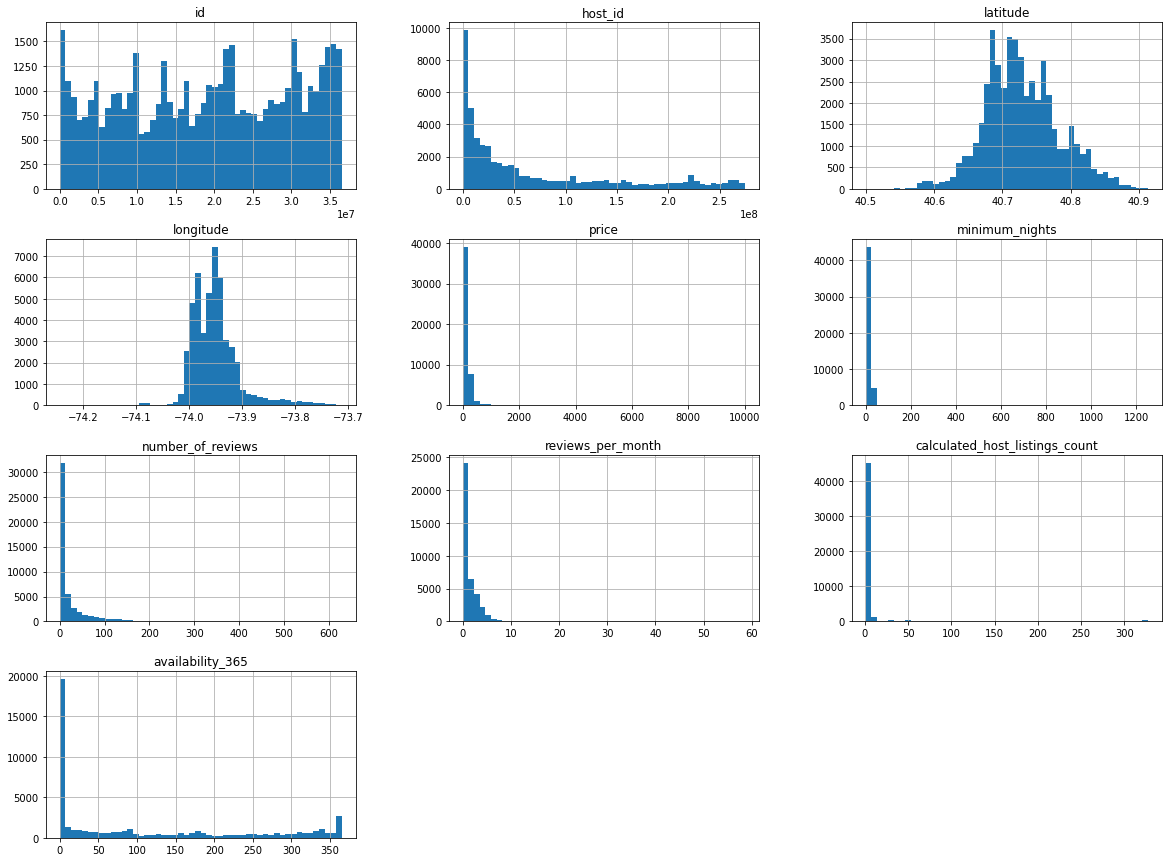

In [34]:
# call histogram method in Pandas
data.hist(bins=50, figsize=(20,15));

Quick insights from histograms above:
- some tail-heavy distributions; A data transformation in here may help - like computing the logarithm.
- normal distributed data for lat/long - they will affect the price predicted? To be discoverd!!
- I don't care IDs - will not impact the model as a first approach.

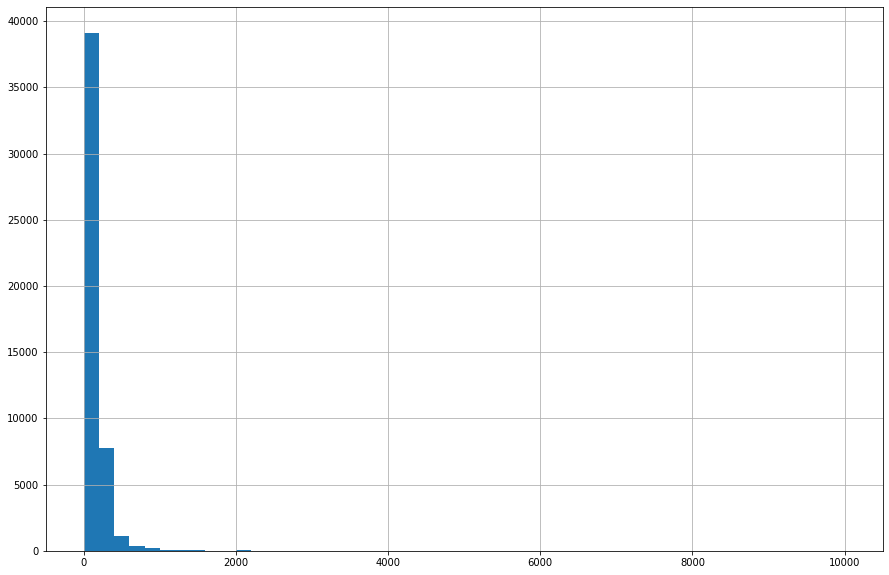

In [35]:
# check price distribution more closely!
data['price'].hist(bins=50, figsize=(15,10));

Some very high values. Outliers?? - need a further investigation.

Let's see if lat/log may give us any data insight. Checking how houses are distributed - geographical info sometimes is very good!
We can check by locations.

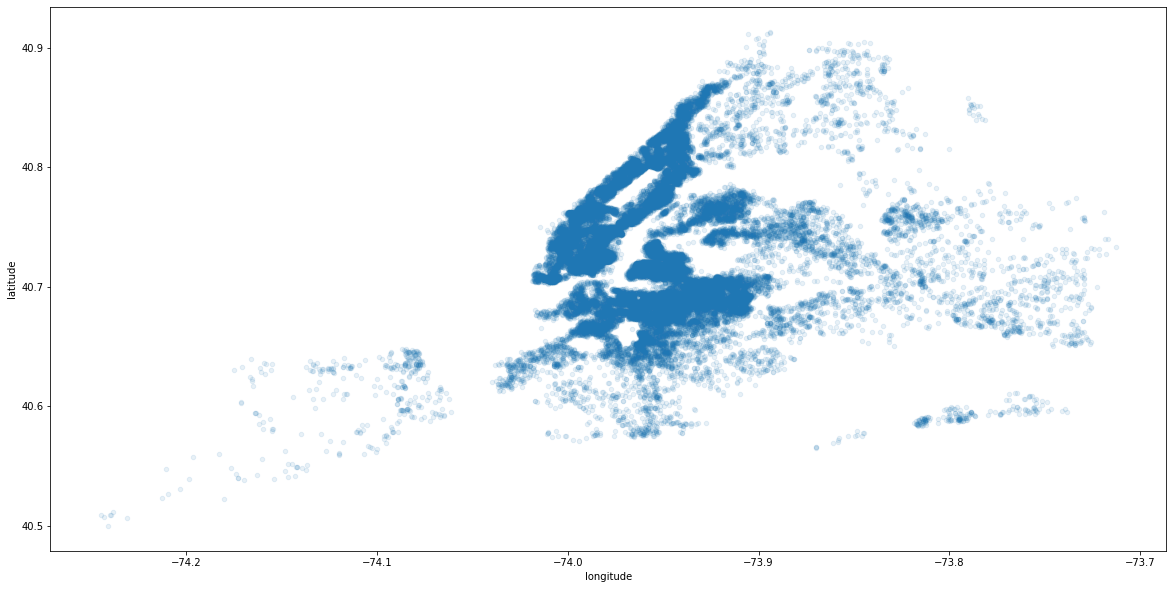

In [43]:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1, figsize=(20,10));

Need more granularity for my geographical plot...let's do it!

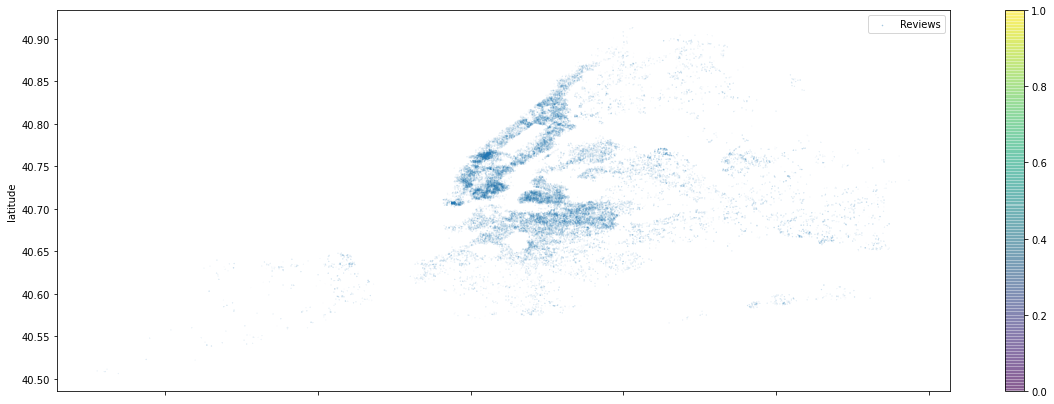

In [48]:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=data['reviews_per_month']/100,
          label='Reviews', figsize=(20,7), colorbar=True);

# Let's plot some categorical features using Seaborn package.

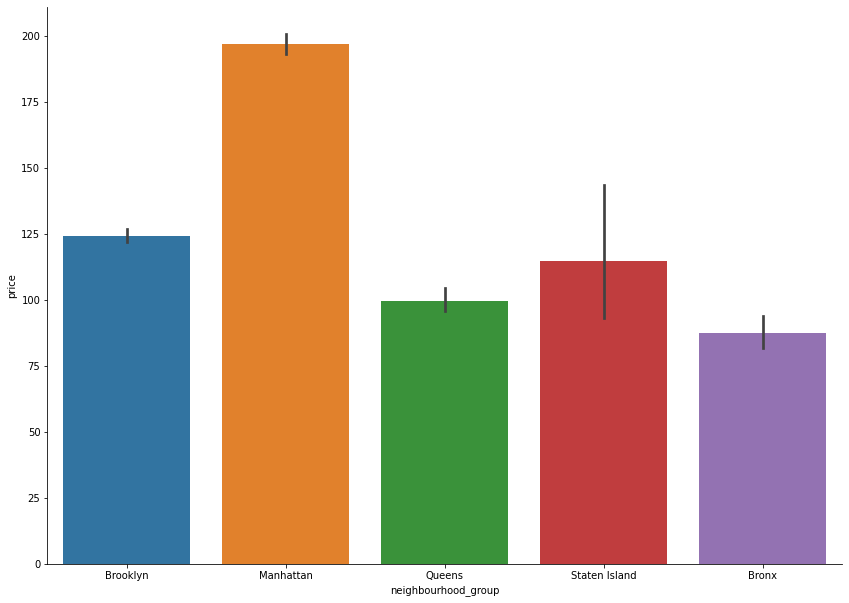

In [51]:
sns.catplot(x='neighbourhood_group', y='price', kind='bar', data=data, height=8.27, aspect=11.7/8.27);

# Check data correlation

In [52]:
data.corr(method='pearson')

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,1.000000,0.588290,-0.003125,0.090908,0.010619,-0.013224,-0.319760,0.291828,0.133272,0.085468
host_id,0.588290,1.000000,0.020224,0.127055,0.015309,-0.017364,-0.140106,0.296417,0.154950,0.203492
latitude,-0.003125,0.020224,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.010142,0.019517,-0.010983
longitude,0.090908,0.127055,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.145948,-0.114713,0.082731
price,0.010619,0.015309,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.030608,0.057472,0.081829
minimum_nights,-0.013224,-0.017364,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.121702,0.127960,0.144303
number_of_reviews,-0.319760,-0.140106,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.549868,-0.072376,0.172028
reviews_per_month,0.291828,0.296417,-0.010142,0.145948,-0.030608,-0.121702,0.549868,1.000000,-0.009421,0.185791
calculated_host_listings_count,0.133272,0.154950,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.009421,1.000000,0.225701
availability_365,0.085468,0.203492,-0.010983,0.082731,0.081829,0.144303,0.172028,0.185791,0.225701,1.000000


#Preprocessing - Data Cleansing

Let's build a data pipeline to take of missing values and any categorical feature. Also, wrap all the steps using Column Transformer.
- Numerical attributes - SimpleImputer to deal with missing data, and scaling values with StanderScaler.
- Categorical attributes - OneHotEncoder method: sparse-matrix